In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
import model_UNet
from data_augmentation import augmentation
import matplotlib.pyplot as plt
from data_into_loaders import get_data

In [29]:
#### Hyper-Param ####

# device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable GPU support
print(f'Using device: {device}')

# data parms
supervised_percent = 0.2  # what percent of training is to be labelled
img_resize = 64             # resize all images to this size 
is_mixed_labels = True     # Training only on supervised data or not - Turning this to true will make the model train on 100% labelled

# model params
depth = 3               # depth of unet
dropout_rate = 0.25     # dropout rate in Unet

# Training params
batch_size = 32
epochs = 30         # total epochs  
wait_period = 10    # how many epochs before unsupervised kicks in
ramp_up = 10        # how many epochs for unsupervised weight to fully kick in (after wait_period)
# consistency = 1
alpha = 3           # how strong is the unsupervised loss gradient
# global_step = 0
lr = 1e-3           # starting learning rate
lr_gamma = 0.9      # lr decays by this amount every epoch

Using device: cuda:0


In [30]:
#Weigth coef for the Unsupervised
def dice_loss(logits, targets, is_modelT_preds=True): 
  if is_modelT_preds:
    targets_animal = torch.unsqueeze(targets, dim=1)
  targets_animal = torch.squeeze(targets)
  preds_animal = F.softmax(logits, dim=1)
  preds_animal = preds_animal[:,1,:,:]
  eps = 1e-6
  intersection = (preds_animal * targets_animal).sum()
  dice_coef = (2. * intersection + eps) / ((preds_animal**2).sum() + (targets_animal**2).sum() + eps)
  dice_loss = 1 - dice_coef
  return dice_loss

@torch.no_grad()
def wt(rampup_length, current, alpha, wait_period = 5):
  
  if current < wait_period:
    return 0.0
  else:
    if rampup_length == 0:
                return 1.0
    else:
        current = np.clip(current - wait_period, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(alpha * np.exp(-5.0 * phase * phase))


def wt_pseudo(rampup_length, current, alpha, wait_period):
  T1 = wait_period
  T2 = wait_period + rampup_length
  t = current
  if t < T1:
    alpha = 0
  elif t < T2:
    alpha = alpha * (t - T1) / (T2 - T1)
  else:
    alpha
  return alpha

#update the Teacher weight
@torch.no_grad()
def update_ema_variables(model, ema_model, alpha, global_step): 
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


def unsup_loss(z, modelT, imgs, unsup_crit): 

  imgT_aug = augmentation(imgs).type(torch.float32)
  imgT_aug = imgT_aug.to(device)

  # z_bar will act as pseudo-labels
  with torch.no_grad():
    z_bar = modelT(imgT_aug)
    # z_bar = F.softmax(z_bar, dim = 1)
    z_bar_preds = torch.argmax(z_bar, dim=1)

  # Transform z_bar into predictions
  # Lu = unsup_crit(z, z_bar_preds).to(device)
  Lu = dice_loss(z, z_bar_preds, is_modelT_preds=True)

  return Lu

@torch.no_grad()
def evaluate_model(model, dataloader, device):
  
  model.eval()
  intersection_total, union_total = 0, 0
  pixel_correct, pixel_count = 0, 0
    
  for data in dataloader:
    imgs, labels = data
    imgs, labels = imgs.to(device), labels.to(device)
    logits = model(imgs)
    preds = torch.argmax(logits, dim=1)
    targets = torch.squeeze(labels)
            
    intersection_total += torch.logical_and(preds, targets).sum()
    union_total += torch.logical_or(preds, targets).sum()
            
    pixel_correct += (preds == targets).sum()
    pixel_count += targets.numel()

  iou = (intersection_total / union_total).item()
  accuracy = (pixel_correct / pixel_count).item()
  
  model.train()
  return accuracy, iou

In [31]:
#### Initialisation ####
#create 2 network
modelS = model_UNet.UNet(in_channels=3, num_classes=2, depth=depth)
modelS = modelS.to(device)
modelT = model_UNet.UNet(in_channels=3, num_classes=2, depth=depth)
modelT = modelT.to(device)
#create the losses
sup_crit = nn.CrossEntropyLoss().to(device)
unsup_crit = nn.CrossEntropyLoss().to(device)
#optimizer
optimizer = Adam(modelS.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma, last_epoch=-1, verbose=True)


/home/fred/repositories/comp0197-cw2/model_UNet.py:213: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/home/fred/repositories/comp0197-cw2/model_UNet.py:214: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Adjusting learning rate of group 0 to 1.0000e-03.


In [32]:
##data loader
mixed_train_loader, val_loader, test_loader = get_data(supervised_percent,1-supervised_percent,0.2,0.1, batch_size=batch_size, img_resize=img_resize, is_mixed_loader=is_mixed_labels)

Using downloaded and verified file: ./data/images.tar.gz
Using downloaded and verified file: ./data/annotations.tar.gz
all images are =  7393


In [33]:
# continue from a previous trained model

# modelS = model_UNet.UNet(num_classes=2, in_channels=3, depth=3)
# modelS.load_state_dict(torch.load('models/unet_supervised_depth3_v1'))
# modelS.to(device)
# optimizer = Adam(modelS.parameters(), lr=lr)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma, last_epoch=-1, verbose=True)

In [34]:
# Train
save_freq = 5
eval_freq = 1
losses, accs, IOUs = [], [], []

for epoch in range(epochs):

        modelS.train()
        running_loss = 0
        running_loss_sup = 0
        running_loss_unsup = 0

        w_t = wt_pseudo(rampup_length=ramp_up, current=epoch, alpha=alpha, wait_period=wait_period)

        for step, data in enumerate(mixed_train_loader):

            imgs, labs = data
            # Augment images
            # imgS_aug = augmentation(imgs)
            # transform_weak = return_weak_transform()
            # transform_strong_generator = return_strong_transform()
            # transform_strong = transform_strong_generator()
            # imgs_weak = transform_weak(imgs).type(torch.float32)
            # labs_weak = transform_weak(labs).type(torch.float32)
            
            # imgs_strong = transform_strong(imgs).type(torch.float32)
            # labs_strong = transform_strong(labs).type(torch.float32)
            # labs_strong = torch.round(labs_strong)
            # labs_strong = labs_strong.squeeze().type(torch.LongTensor).to(device)
            
            imgs_weak = augmentation(imgs).to(device)
            labs = labs.squeeze().type(torch.LongTensor)
            labs = labs.to(device)
            
            # imgs_strong = imgs_strong.to(device)
            # imgs_weak = imgs_weak.to(device)

            optimizer.zero_grad()

            # Forward pass for student and teacher
            z = modelS(imgs_weak)
            # z_bar = modelT(imgs_weak)
            
            # z_bar_strong = transform_strong(z_bar)
            # z_bar_strong = torch.argmax(z_bar_strong, dim=1)
             

            # Find img with label
            sup_idx = np.asarray(torch.tensor([(elem != -1).item() for elem in labs[:, 0, 0]])) #If batchsize is the first dim
            sup_num = sup_idx.sum()
            total_num = labs.shape[0]

            if sup_num == 0:
              print('sup_idx == 0')
              Ls = torch.tensor(0)
            else:
              # Calculate losses
              Ls = (1/sup_num) * sup_crit(z[sup_idx], labs[sup_idx])
              # Ls = dice_loss(z[sup_idx], labs_strong[sup_idx])
            
            # Lu = unsup_loss(z, modelT, imgs, unsup_crit)
            with torch.no_grad():
              target_unsup = torch.argmax(z, dim=1)
            Lu = (1/total_num) * unsup_crit(z, target_unsup)
    
            loss = Ls + w_t * Lu
            
            loss.backward()
            
            optimizer.step()    
            # global_step += 1
            # update_ema_variables(modelS, modelT, alpha, global_step)
            running_loss += loss.item()
            running_loss_sup += Ls.item()
            running_loss_unsup += Lu.item()
            

            #optimizer.param_groups[0]['lr'] = lr(epoch+2)
            #print(loss.item())
        scheduler.step()

        print(f'Epoch: {epoch + 1:4d} - Loss: {running_loss:6.2f}, loss_sup: {running_loss_sup:6.1f}, loss_unsup: {running_loss_unsup:6.1f}, w_t: {w_t: 3.2f}')
        losses.append(running_loss)

        if (epoch % eval_freq == 0):
          accuracy, IOU = evaluate_model(modelS, val_loader, device)
          accs.append(accuracy)
          IOUs.append(IOU)
          print(f'accuracy: {accuracy:2.0%}; IOU: {IOU:2.0%}')
        if ((epoch+1) % save_freq == 0):
          modelS.to('cpu')
          torch.save(modelS.state_dict(), f'models/pseudo_supervised_{epoch+1}epochs')
          modelS.to(device)
          print('saved model')

np.savetxt("losses", losses)
np.savetxt("accs", accs)
np.savetxt("IOUs", IOUs)

Adjusting learning rate of group 0 to 9.0000e-04.
Epoch:    1 - Loss:  20.29, loss_sup:   20.3, loss_unsup:    2.7, w_t:  0.00
accuracy: 69%; IOU: 54%
Adjusting learning rate of group 0 to 8.1000e-04.
Epoch:    2 - Loss:  19.00, loss_sup:   19.0, loss_unsup:    2.2, w_t:  0.00
accuracy: 66%; IOU: 26%
Adjusting learning rate of group 0 to 7.2900e-04.
Epoch:    3 - Loss:  16.35, loss_sup:   16.4, loss_unsup:    1.6, w_t:  0.00
accuracy: 72%; IOU: 45%
Adjusting learning rate of group 0 to 6.5610e-04.
Epoch:    4 - Loss:  15.56, loss_sup:   15.6, loss_unsup:    1.5, w_t:  0.00


In [ ]:
modelS.to('cpu')
torch.save(modelS.state_dict(), 'models/test_now')
modelS.to(device)

UNet(
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_final): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (up_convs): ModuleList(
    (0): UpConv(
      (upconv): ConvTranspose2d(256, 128, kernel_size=(2, 2), str

In [ ]:
modelS.load_state_dict(torch.load('models/unet_supervised_depth3_M9_epoch10'))
modelS.to(device)

UNet(
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_final): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (up_convs): ModuleList(
    (0): UpConv(
      (upconv): ConvTranspose2d(256, 128, kernel_size=(2, 2), str

In [ ]:
data = next(iter(mixed_train_loader))
imgs, labs = data
# Augment images
# imgS_aug = augmentation(imgs)
transform_weak = return_weak_transform()
transform_strong = return_strong_transform()

In [ ]:
transform_strong_generator = return_strong_transform()
transform_strong = transform_strong_generator()

In [ ]:

imgs_weak = transform_weak(imgs).type(torch.float32)
labs_weak = transform_weak(labs).type(torch.float32)
imgs_strong = transform_strong(imgs_weak).type(torch.float32)
labs_strong = transform_strong(labs_weak).type(torch.float32)

In [ ]:
from torchvision import transforms

In [ ]:
transforms.RandomAffine.get_params(imgs, degrees=100, translate=None, scale_ranges=(0.5,1), shears=None, img_size=(64,64))

TypeError: RandomAffine.get_params() got multiple values for argument 'degrees'

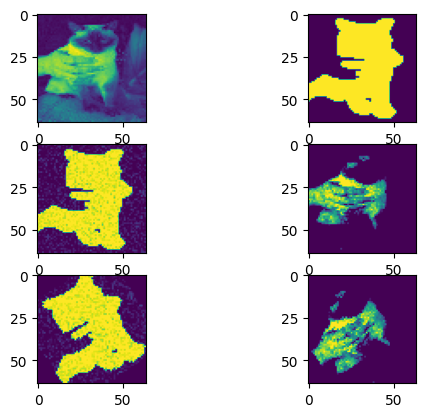

In [ ]:
fig, axs = plt.subplots(3,2)
id = 1

axs[0,0].imshow(imgs[id,0])
axs[0,1].imshow(labs[id,0])
axs[1,1].imshow(imgs_weak[id,0])
axs[1,0].imshow(labs_weak[id,0])
axs[2,1].imshow(imgs_strong[id,0])
axs[2,0].imshow(labs_strong[id,0])


In [ ]:

imgs_weak = transform_weak.get_params(imgs).type(torch.float32)
labs_weak = transform_weak(labs).type(torch.float32)

imgs_strong = transform_strong(imgs_weak).type(torch.float32)
labs_strong = transform_strong(labs_weak).type(torch.float32)
labs_strong = torch.round(labs_strong)
labs_strong = torch.LongTensor(labs_strong)

In [ ]:
transforms.RandomCrop.get_params(
            imgs, output_size=(64, 64))

(0, 0, 64, 64)

In [ ]:
transforms.RandomRotation.get_params(imgs, degrees=(-100,100))

TypeError: RandomRotation.get_params() got multiple values for argument 'degrees'